In [1]:
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt
import os
import sys
from unet_full import UNetLike


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")   # or "cuda:0" if you only have one GPU
    torch.cuda.set_device(device)
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("No GPU detected — using CPU instead.")

print(f"Current device variable: {device}")


Using GPU: NVIDIA GeForce RTX 3090
Current device variable: cuda:0


In [3]:
seed = 0

#random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False #

In [4]:
# The idea here is to train an UNET auto encoder 
# Maybe, the network will realize which features to preserve in the encoding process and 
# and we can use a subsequent feed-forward neural network to classify pixels 

def normalize_img_inputs(folder_path):

    list_files = os.listdir(folder_path)
    list_im = []

    for f in sorted(list_files):
        if '.npy' in f:
            full_image_name = os.path.join(folder_path, f)
            im = np.load(full_image_name)
            # Normalize
            im_normalized = (im - np.min(im)) / (np.max(im) - np.min(im))
            list_im.append(im_normalized)

    return list_im

def compile_img_list(data_path):

    list_files = os.listdir(data_path)
    list_im = []
    for f in sorted(list_files):
        if '.tif' in f:
            full_image_name = os.path.join(data_path, f)
            im = np.load(full_image_name)
            # Normalize
            im_normalized = (im - np.min(im)) / (np.max(im) - np.min(im))
            list_im.append(im_normalized)

    return list_im

def transform_to_3channels(im, labels):# First we define the device - we want to train on the GPU
    im_out = np.zeros((3, im.shape[0], im.shape[1]))
    im_out[0, :, :] = im == labels[0]
    im_out[1, :, :] = im == labels[1]
    im_out[2, :, :] = im == labels[2]

    return im_out

def transform_list_labels(list_labels):
    list_transformed = []
    labels = [0, 128, 255]
    for im in list_labels:
        im_transformed = transform_to_3channels(im, labels)
        list_transformed.append(im_transformed)

    return list_transformed

# The custom datasets class
class RawDataset(Dataset):
    def __init__(self, raw_list, label_list):
        self.raw_images = raw_list
        self.label_images = label_list

    def __len__(self):
        return len(self.raw_images)

    def __getitem__(self, idx):
        
        image_raw = self.raw_images[idx]
        image_raw_f = image_raw.astype(np.float32)
        image_label = self.label_images[idx]
        image_label_f = image_label.astype(np.float32)
        

        # We make normalization for the raw data
        image_raw_norm = torch.from_numpy(image_raw_f).float()
        image_raw_final = image_raw_norm.unsqueeze(0)
        # Only conversion for the labels 
        image_label_converted = torch.from_numpy(image_label_f).float()
        image_label_final = image_label_converted.unsqueeze(0)
        
        return image_raw_final, image_label_final

def extract_first_layer_features(model, input_data):
    # Ensure the model is in evaluation mode if you are not training
    model.eval()
    
    # Pass the input through the first convolutional layer of conv1
    first_layer_output = model.conv1[0](input_data)
    
    return first_layer_output



In [5]:
#ADDING IOU and Dice Score

In [6]:
def dice_iou_from_logits(logits, target, eps=1e-6, thr=0.5):
    probs = torch.sigmoid(logits)
    pred = (probs > thr).float()
    target = target.float()
    inter = (pred * target).sum(dim=(2,3))
    pred_sum = pred.sum(dim=(2,3))
    target_sum = target.sum(dim=(2,3))
    union = pred_sum + target_sum - inter
    dice = (2*inter + eps) / (pred_sum + target_sum + eps)
    iou = (inter + eps) / (union + eps)
    return dice.mean().item(), iou.mean().item()


In [10]:
# 
#input_file_path = '/data/data_circles/dif_samples/simulation_reco' #so we were using this dataset
#input_file_path = '/data/data_circles/dif_samples/simulation_noise' #folder with 1000
#label_file_path = '/data/data_circles/dif_samples/structure_padding' #folder with 1000

input_file_path = "/home/nmlre/PhD/Courses/DL/project/Sandstone/Sandstone_256x256x1000/Bentheimer/slices_256_npy"
label_file_path = "/home/nmlre/PhD/Courses/DL/project/Sandstone/Sandstone_256x256x1000/Bentheimer/slices_binary_256_npy"

inputs = normalize_img_inputs(input_file_path)
labels = normalize_img_inputs(label_file_path)

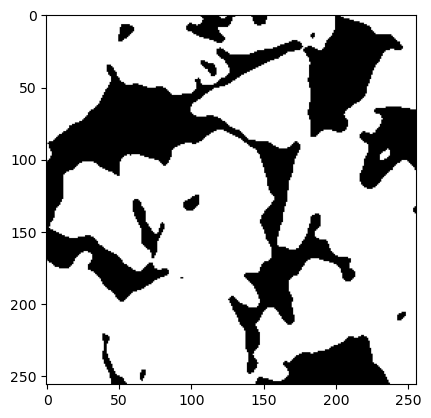

(256, 256)
1.0 0.0
float64


In [11]:
img = inputs[100]
label = labels[100]

plt.figure() 
plt.imshow(label, cmap='gray')
plt.show()

print(label.shape)
print(np.max(label), np.min(label))
print(label.dtype)

In [12]:
# Loadind the data 
train_dataset = RawDataset(inputs, labels)

# Perform the split between train, validation and test
total_size = len(train_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(train_dataset, [train_size, val_size, test_size],generator=torch.Generator().manual_seed(seed))

# Load the datasets as individual data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [13]:
#print(next(unet.parameters()).device)
#print(inputs.device)


In [14]:
# Training cycle 
# Define our model - the model only requires input and output channels
#unet = UNET(1,1).to(device)
unet = UNetLike(in_channels=1, num_classes=1).to(device)
#criterion = torch.nn.BCEWithLogitsLoss()
criterion = torch.nn.BCELoss() #this one seems to work fine now
optimizer = optim.Adam(unet.parameters(), lr=0.0001) #0.01 before

#testing wit AdamW
#optimizer = optim.AdamW(unet.parameters(), lr=0.001, weight_decay=1e-4) #0.01 before
#optimizer = optim.AdamW(unet.parameters(), lr=0.001)
num_epochs = 50 #200

# Initialize the lists
train_loss_list = [] 
val_loss_list = []

# We loop through the batches
for epoch in range(0, num_epochs):
    print(f"Training Epoch {epoch}")
    unet.train()
    train_loss = 0
    for data in train_loader:

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        #inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        # Here is where the model makes its predictions
        outputs = unet(inputs)
        ####test
        probabilities = torch.sigmoid(outputs) #for BCE
        ####
        # Calculating the loss function requires labels
        #loss = criterion(outputs, labels)
        loss = criterion(probabilities, labels) #for BCE
        # Back propagation
        loss.backward()
        optimizer.step()
        # Store the loss per batch 
        train_loss += loss.item()
        
    # Update the train loss
    av_train_loss = train_loss / len(train_loader)
    
    # Starting the validation loss 
    unet.eval()
    val_loss = 0 
    with torch.no_grad():
        for data in val_loader:
            
            inputs, labels = data
            #inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = unet(inputs)
            probabilities = torch.sigmoid(outputs) #for BCE
            #loss = criterion(outputs, labels)
            loss = criterion(probabilities, labels)  #for BCE
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    av_val_loss = val_loss / len(val_loader)
    # Store the values for later plotting
    train_loss_list.append(av_train_loss)
    val_loss_list.append(av_val_loss)

    # Printing for checking 
    print(f"Epoch: {epoch} - Train loss: {av_train_loss} - Val loss: {av_val_loss}")
    

    # --- Compute Dice and IoU on validation set ---
    all_dice, all_iou = [], []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            #inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = unet(inputs)
            d, i = dice_iou_from_logits(outputs, labels)
            all_dice.append(d)
            all_iou.append(i)

    mean_dice = np.mean(all_dice)
    mean_iou = np.mean(all_iou)
    print(f"Validation Dice: {mean_dice:.4f}, IoU: {mean_iou:.4f}")



Training Epoch 0
Epoch: 0 - Train loss: 0.6820680065588518 - Val loss: 0.5945425799914769
Validation Dice: 0.8443, IoU: 0.7313
Training Epoch 1
Epoch: 1 - Train loss: 0.451568986881863 - Val loss: 0.32807507259505136
Validation Dice: 0.8871, IoU: 0.7975
Training Epoch 2
Epoch: 2 - Train loss: 0.2251016213135286 - Val loss: 0.13314275230680192
Validation Dice: 0.9856, IoU: 0.9716
Training Epoch 3
Epoch: 3 - Train loss: 0.07613608698275956 - Val loss: 0.04973597239170756
Validation Dice: 0.9866, IoU: 0.9736
Training Epoch 4
Epoch: 4 - Train loss: 0.04398717832836238 - Val loss: 0.03848096142922129
Validation Dice: 0.9898, IoU: 0.9799
Training Epoch 5
Epoch: 5 - Train loss: 0.036324788223613395 - Val loss: 0.03262850855078016
Validation Dice: 0.9911, IoU: 0.9823
Training Epoch 6
Epoch: 6 - Train loss: 0.03186852095479315 - Val loss: 0.029562202947480336
Validation Dice: 0.9918, IoU: 0.9838
Training Epoch 7
Epoch: 7 - Train loss: 0.02860315287993713 - Val loss: 0.02679290436208248
Validati

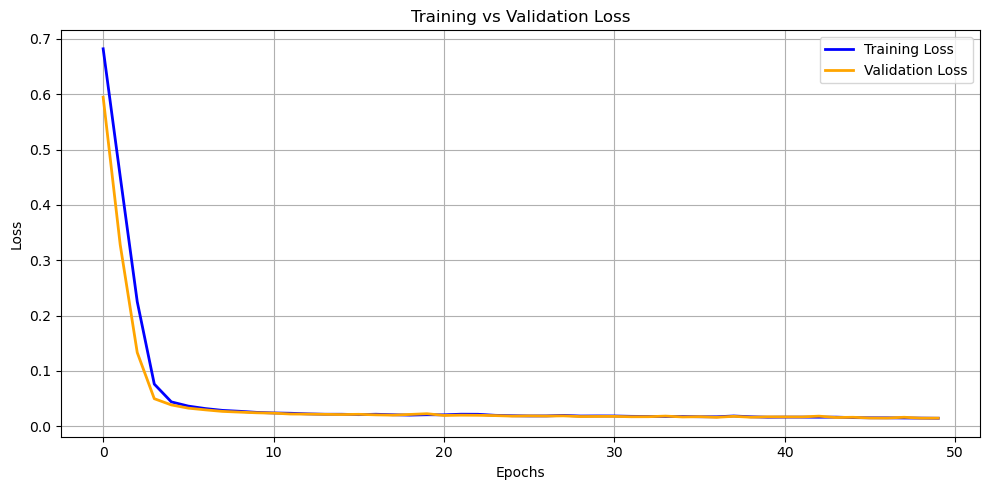

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_loss_list, label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [16]:
# --- Evaluation on the test set ---
unet.eval()  # <- very important


all_dice, all_iou = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = unet(inputs)

        d, i = dice_iou_from_logits(outputs, labels)
        all_dice.append(d)
        all_iou.append(i)

mean_dice = np.mean(all_dice)
mean_iou = np.mean(all_iou)
print(f"Test Dice: {mean_dice:.4f}, IoU: {mean_iou:.4f}")


Test Dice: 0.9957, IoU: 0.9914


In [17]:
#import torchmetrics.functional.classification as tmf
#print([n for n in dir(tmf) if 'dice' in n or 'jaccard' in n])


In [18]:
#from torchmetrics.functional.classification import binary_f1_score

In [19]:
from torchmetrics.functional.classification import binary_f1_score

unet.eval()
f1_scores = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        logits = unet(inputs)
        preds = ((torch.sigmoid(logits)) > 0.5).int()
        labels = labels.int()

        f1 = binary_f1_score(preds, labels)
        f1_scores.append(f1.item())

print(f"TorchMetrics Dice (via F1): {sum(f1_scores)/len(f1_scores):.4f}")


TorchMetrics Dice (via F1): 0.9957


In [20]:
#print("Batch size:", el_raw.shape[0])
import torchmetrics
print(torchmetrics.__version__)



1.8.2


In [21]:
#print("Predicted min:", im_predicted_np.min())
#print("Predicted max:", im_predicted_np.max())

#print("Predicted min:", probabilities.min())
#print("Predicted max:", probabilities.max())

#probabilities.dtype


In [22]:
for batch in test_loader:
    el_raw, el_label = batch
    break

In [23]:
i = 2  # or any index < el_raw.shape[0]
im_raw = el_raw[i]       # shape: (C, H, W)
im_label = el_label[i]   # shape: (H, W) or (1, H, W)

In [24]:
im_input = im_raw.unsqueeze(0).cuda()  # shape: (1, C, H, W)
unet.eval()
with torch.no_grad():
    im_predicted = unet(im_input)      # shape: (1, 1, H, W)
    probabilities = torch.sigmoid(im_predicted)  # shape: (1, 1, H, W)

In [25]:
im_predicted

tensor([[[[ 4.1546,  7.0403,  8.3189,  ...,  5.9059,  4.1741,  2.2174],
          [ 7.1992, 12.1259, 14.0849,  ...,  8.7886,  5.8579,  2.9253],
          [ 8.9079, 14.7622, 17.3748,  ...,  8.1461,  4.7470,  1.9220],
          ...,
          [ 5.8139,  9.7418, 11.7879,  ..., 13.4929, 11.0686,  6.3326],
          [ 4.9084,  8.1322,  9.8045,  ..., 11.0932,  9.1152,  5.0839],
          [ 2.8822,  4.7206,  5.6899,  ...,  6.3826,  5.1596,  2.7837]]]],
       device='cuda:0')

In [26]:
probabilities

tensor([[[[0.9845, 0.9991, 0.9998,  ..., 0.9973, 0.9848, 0.9018],
          [0.9993, 1.0000, 1.0000,  ..., 0.9998, 0.9972, 0.9491],
          [0.9999, 1.0000, 1.0000,  ..., 0.9997, 0.9914, 0.8724],
          ...,
          [0.9970, 0.9999, 1.0000,  ..., 1.0000, 1.0000, 0.9982],
          [0.9927, 0.9997, 0.9999,  ..., 1.0000, 0.9999, 0.9938],
          [0.9470, 0.9912, 0.9966,  ..., 0.9983, 0.9943, 0.9418]]]],
       device='cuda:0')

In [27]:
im_raw_np = im_raw.cpu().numpy().squeeze()
im_label_np = im_label.cpu().numpy().squeeze()
im_predicted_np_unet = im_predicted.squeeze().detach().cpu().numpy()
#im_predicted_np = outputs.squeeze().detach().cpu().numpy() #is this the same as im__predicted?
im_predicted_np = probabilities.squeeze().detach().cpu().numpy()

In [28]:
im_predicted_np.shape

(256, 256)

In [29]:
print(im_predicted_np.min(), im_predicted_np.max()) 

9.787715e-11 1.0


In [30]:
im_predicted_np

array([[0.98454976, 0.99912494, 0.99975616, ..., 0.99728394, 0.9848439 ,
        0.9018038 ],
       [0.99925333, 0.99999464, 0.9999993 , ..., 0.99984753, 0.9971511 ,
        0.94908506],
       [0.9998647 , 0.99999964, 1.        , ..., 0.99971014, 0.99139684,
        0.8723656 ],
       ...,
       [0.99702305, 0.99994123, 0.9999924 , ..., 0.99999857, 0.9999844 ,
        0.99822575],
       [0.9926697 , 0.9997061 , 0.9999448 , ..., 0.99998474, 0.99988997,
        0.9938426 ],
       [0.946959  , 0.9911686 , 0.9966313 , ..., 0.9983121 , 0.99428856,
        0.94179   ]], shape=(256, 256), dtype=float32)

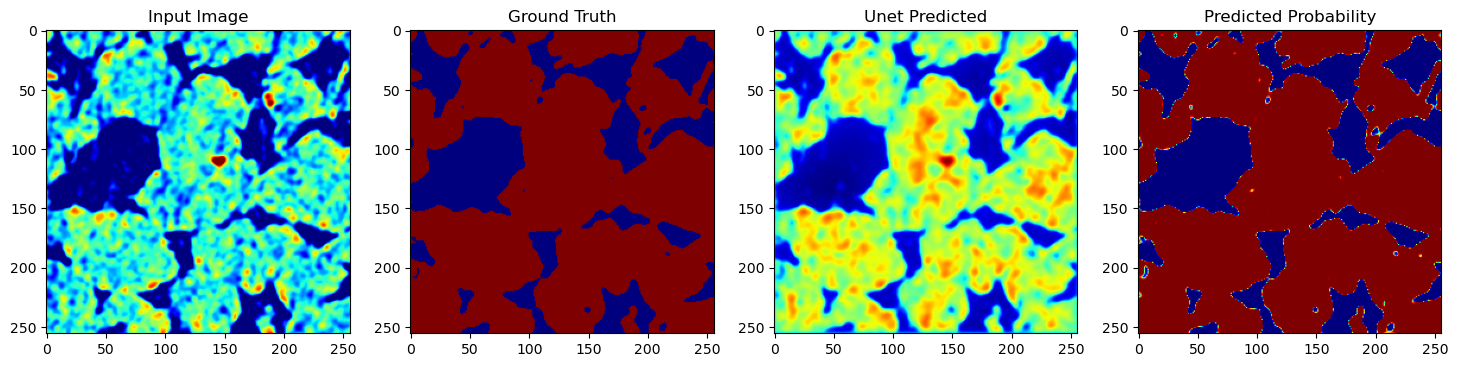

In [31]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.imshow(im_raw_np, cmap='jet')
plt.title('Input Image')

plt.subplot(1, 4, 2)
plt.imshow(im_label_np, cmap='jet')
plt.title('Ground Truth')

plt.subplot(1, 4, 3)
plt.imshow(im_predicted_np_unet, cmap='jet')
plt.title('Unet Predicted')

plt.subplot(1, 4, 4)
plt.imshow(im_predicted_np, cmap='jet')
plt.title('Predicted Probability')

#plt.subplot(1, 4, 4)
#plt.imshow(im_predicted_np[0], cmap='jet')
#plt.title('Predicted Probability? (outputs)')

plt.show()

In [32]:
print("Predicted min:", im_predicted_np_unet.min())
print("Predicted max:", im_predicted_np_unet.max())

Predicted min: -23.047308
Predicted max: 55.62154


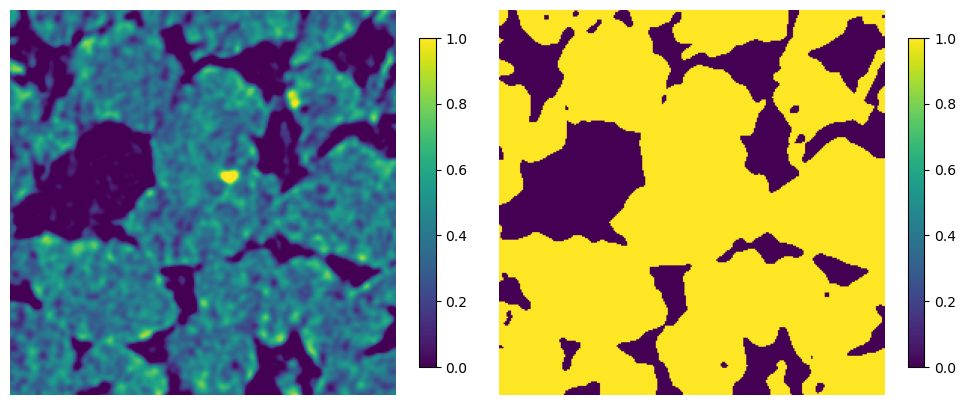

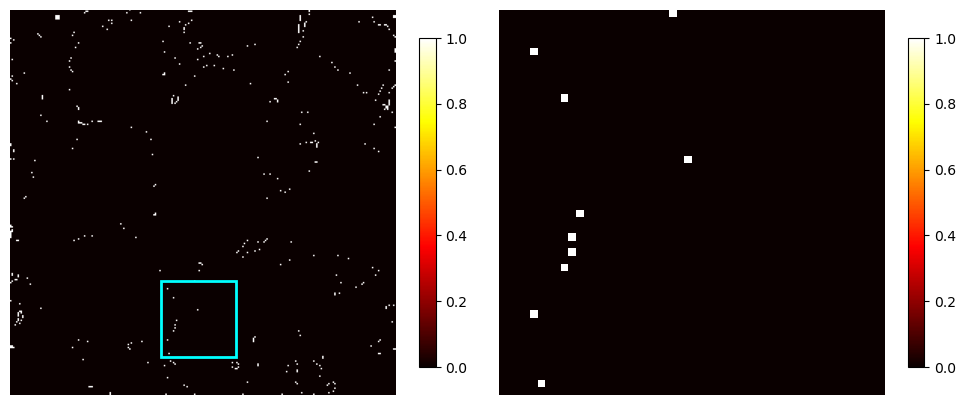

In [33]:

# --- Compute binary prediction and difference ---
pred_bin = (im_predicted_np > 0.5).astype(np.uint8)
diff = np.abs(im_label_np - pred_bin)

# =============================
# 1. Figure: Input + Prediction
# =============================
fig1, axes1 = plt.subplots(1, 2, figsize=(10, 5))
images = [im_raw_np, pred_bin]
titles = ['Input', 'Prediction']

for ax, img, title in zip(axes1, images, titles):
    imshow_obj = ax.imshow(img, cmap='viridis')
    #ax.set_title(title)
    ax.axis('off')
    fig1.colorbar(imshow_obj, ax=ax, shrink=0.7)

plt.tight_layout()

# =============================
# 2. Figure: Difference + Zoom
# =============================

# Coordinates for zoom region (edit as needed)
x_start, x_end = 100, 150
y_start, y_end = 180, 230

zoom_crop = diff[y_start:y_end, x_start:x_end]

fig2, axes2 = plt.subplots(1, 2, figsize=(10, 5))
images2 = [diff, zoom_crop]
titles2 = ['|Predicted − Ground Truth|', 'Zoomed Region']

for ax, img, title in zip(axes2, images2, titles2):
    imshow_obj = ax.imshow(img, cmap='hot')
    
    #ax.set_title(title)
    ax.axis('off')
    fig2.colorbar(imshow_obj, ax=ax, shrink=0.7)

# Optional: mark zoom region on full difference
rect = plt.Rectangle((x_start, y_start), x_end - x_start, y_end - y_start,
                     edgecolor='cyan', facecolor='none', linewidth=2)
axes2[0].add_patch(rect)

plt.tight_layout()
plt.show()

# --- Save both figures ---


#output_dir = "/home/nmlre/PhD/

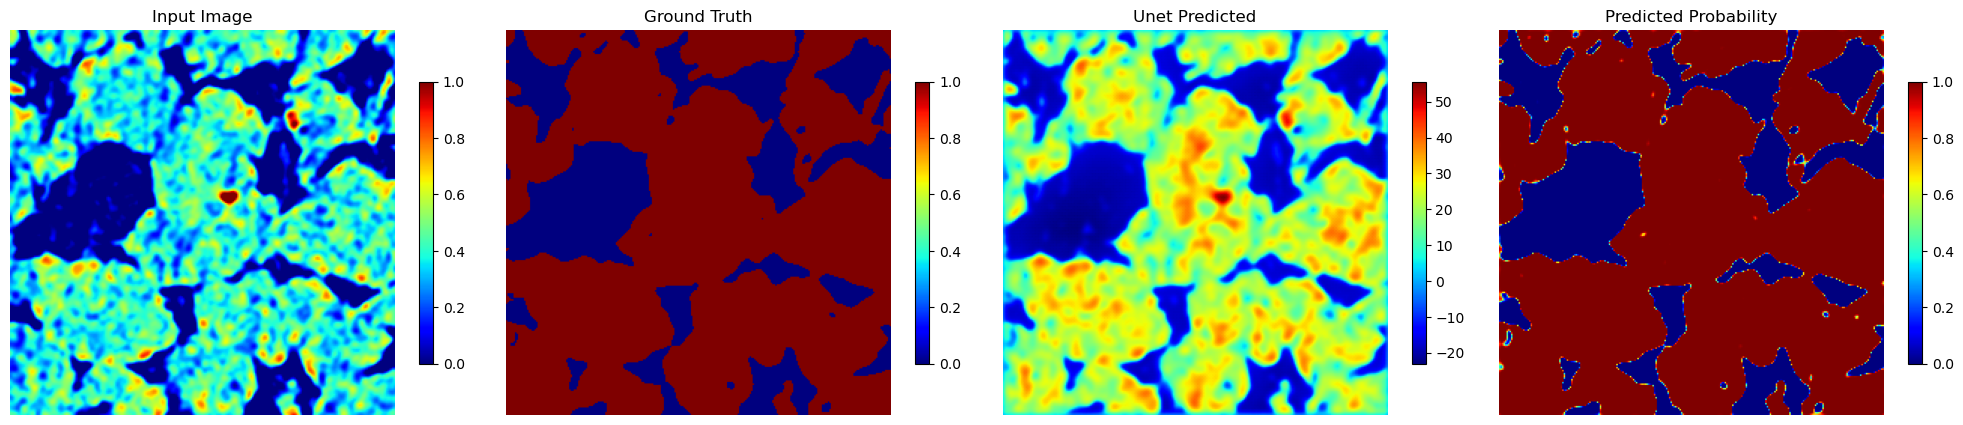

In [34]:
# Create a grid of subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
#titles = ['Original Mask', 'Padded Mask', 'Reconstruction', 'Noisy Output']
#images = [mask, im_padded, reco, noise_image]
titles = ['Input Image','Ground Truth','Unet Predicted','Predicted Probability']
images = [im_raw_np, im_label_np, im_predicted_np_unet, im_predicted_np]

# Display each image
for ax, img, title in zip(axes, images, titles):
    im = ax.imshow(img, cmap='jet')
    ax.set_title(title)
    ax.axis('off')
    fig.colorbar(im, ax=ax, shrink=0.6)

plt.tight_layout()
plt.show()

In [36]:
# Save the model 
model_path = 'unet_full_sigmoid_BCELoss_Adam_0001_50ep.pth'
torch.save(unet.state_dict(), model_path)